# Создание модели классификации

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import base64
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import requests
import joblib
import matplotlib.pyplot as plt


from transformers import  AutoProcessor, AutoModel, pipeline
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from PIL import Image
from io import BytesIO
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm, trange

## Модель resnet50

In [ ]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# for param in model.parameters():
#   param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if not name.startswith('layer4') and not name.startswith('fc'):
        param.requires_grad = False

## Модель resnet101

In [ ]:
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 97.2MB/s]


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for name, param in model.named_parameters():
  if not name.startswith('layer4') and not name.startswith('fc'):
      param.requires_grad = False

## DataLoader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, texts, transform=None):
      self.images = images
      self.texts = texts
      self.transform = transform

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      text = self.texts[idx]
      if self.transform:
          image = self.transform(image)

      return image, text

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.RandomChoice([
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

batch_size = 64

In [ ]:
X = merged_df['image']
y = merged_df['Name'].values

In [ ]:
images = [Image.open(BytesIO(base64.b64decode(bs4_url))).convert("RGB") for bs4_url in X]

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
y_encoded = label_encoder.fit_transform(y)

In [ ]:
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
len(y_encoded)

15251

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, y_encoded, test_size=0.2, random_state=42)

In [ ]:
train_custom_dataset = CustomDataset(X_train, y_train, train_transform)
val_custom_dataset = CustomDataset(X_val, y_val, train_transform)

train_data_loader = DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_custom_dataset, batch_size=batch_size, shuffle=False)

## Pipline

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], "val": []}
    accuracies = {'train': [], "val": []}

    for epoch in trange(num_epochs, desc="Epoch:"):
        for phase in ['train', 'val']:
            if phase == 'train':
                # scheduler.step()
                model.train(True)
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(data_loader, leave=False, desc=f"{phase} iter:"):
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).to(torch.float32).item()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'Epoch: {epoch}')
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

## Обучение модели

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
n_classes = len(np.unique(y_encoded))

In [ ]:
model.fc = torch.nn.Linear(model.fc.in_features, n_classes)

In [ ]:
model = model.to(device)

In [ ]:
num_epochs = 30

loss = torch.nn.CrossEntropyLoss()
# loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
model, losses, accuracies = train_model(model, loss, optimizer, train_data_loader, val_data_loader, num_epochs, device);

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 5.2198 Acc: 0.0680


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 4.4075 Acc: 0.1278


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 3.7594 Acc: 0.2020


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 3.5484 Acc: 0.2461


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 3.0898 Acc: 0.3138


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 3.5047 Acc: 0.2701


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 2.6726 Acc: 0.3898


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.9265 Acc: 0.3559


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 2.4041 Acc: 0.4384


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.8328 Acc: 0.3854


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 2.1949 Acc: 0.4748


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.7061 Acc: 0.4113


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 2.0284 Acc: 0.5020


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.6375 Acc: 0.4205


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.8645 Acc: 0.5448


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.6446 Acc: 0.4146


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.7766 Acc: 0.5553


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.6085 Acc: 0.4333


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.6437 Acc: 0.5812


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5460 Acc: 0.4497


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.5728 Acc: 0.5962


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5546 Acc: 0.4595


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.4963 Acc: 0.6108


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5706 Acc: 0.4523


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.4214 Acc: 0.6280


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5324 Acc: 0.4595


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.3322 Acc: 0.6463


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5407 Acc: 0.4608


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.2690 Acc: 0.6631


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5846 Acc: 0.4520


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.2351 Acc: 0.6714


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5710 Acc: 0.4605


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.1757 Acc: 0.6793


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5337 Acc: 0.4635


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.1474 Acc: 0.6887


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.4712 Acc: 0.4726


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.1039 Acc: 0.7036


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5217 Acc: 0.4815


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.0490 Acc: 0.7109


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5519 Acc: 0.4759


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.0049 Acc: 0.7237


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5123 Acc: 0.4903


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 1.0078 Acc: 0.7228


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5511 Acc: 0.4779


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.9548 Acc: 0.7305


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.6187 Acc: 0.4707


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.9475 Acc: 0.7355


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5916 Acc: 0.4841


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.9077 Acc: 0.7428


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5565 Acc: 0.4907


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.9079 Acc: 0.7432


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5988 Acc: 0.4789


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.8744 Acc: 0.7512


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5985 Acc: 0.4726


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.8633 Acc: 0.7544


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5454 Acc: 0.4815


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.8341 Acc: 0.7625


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.6620 Acc: 0.4867


train iter::   0%|          | 0/191 [00:00<?, ?it/s]

train Loss: 0.8328 Acc: 0.7628


val iter::   0%|          | 0/48 [00:00<?, ?it/s]

val Loss: 2.5951 Acc: 0.4831
Epoch: 29
Training complete in 95m 38s
Best val Acc: 0.490659


In [ ]:
def plot_losses_and_accuracy(train_losses, val_losses, train_acc, val_acc):
    plt.figure(figsize=(10, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

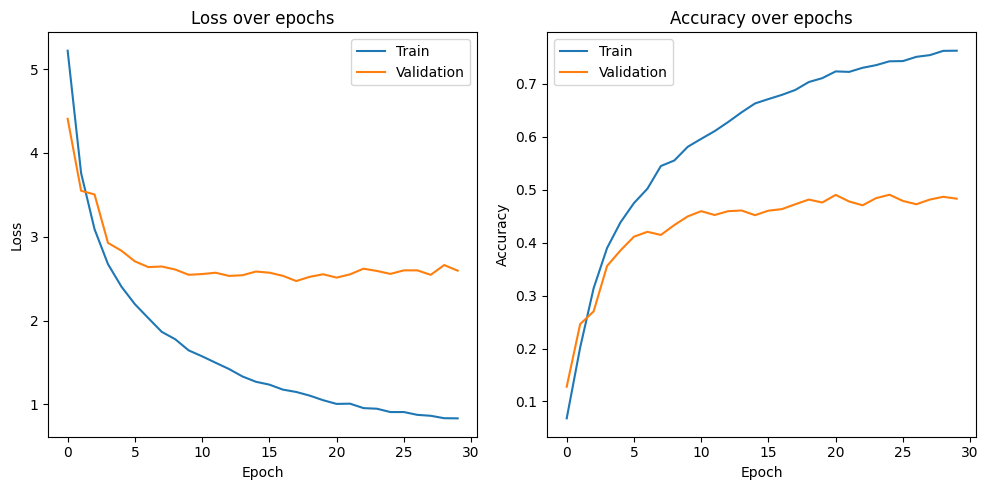

In [ ]:
plot_losses_and_accuracy(losses['train'], losses['val'], accuracies['train'], accuracies['val'])

In [ ]:
PATH = "resnet_101.pth"

torch.save(model.state_dict(), PATH)

## Выбор топ 5 подходящих мест

In [ ]:
# Создаем пустой список для хранения вероятностей классов
probabilities_list = []

for i, image in enumerate(X_val[:1]):
    image_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.topk(5, 1)
        probabilities = torch.sigmoid(outputs).squeeze().tolist()  # Вероятности классов

    probabilities_list.append(probabilities)

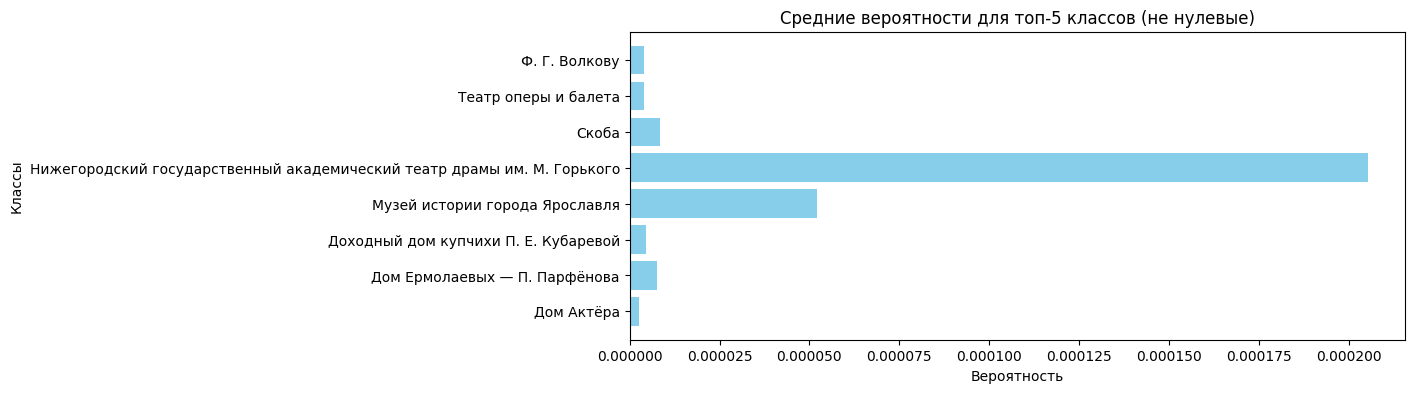

In [ ]:
# Отфильтруем классы с ненулевой вероятностью
nonzero_probabilities = [(label_encoder.inverse_transform([i])[0], mean_probabilities[i]) for i in range(len(mean_probabilities)) if mean_probabilities[i] >= 0.000001]

# Разделим классы и вероятности
classes, probabilities = zip(*nonzero_probabilities)

# Построение гистограммы
plt.figure(figsize=(10, len(classes)*0.5))
plt.barh(range(len(classes)), probabilities, color='skyblue')
plt.xlabel('Вероятность')
plt.ylabel('Классы')
plt.title('Средние вероятности для топ-5 классов (не нулевые)')
plt.yticks(range(len(classes)), classes)
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model.pth')